In this notebook i'll be preparing the training data from the base files supplyed by Márcio Borges. The basic problem i'll be solving is a common oil and gas problem: Given some well points and pressure sensors how to estimate the permeability of the field. The equations that simulate this phenomena comes from fluid flows on porous media.

$$
\vec{v} = -\frac{k(\vec{x})}{\mu}\vec{\nabla}{p}
$$

Subject to:

$$
\vec{\nabla} \cdot \vec{v} = g(\vec{x}) 
$$

Where $g(\vec{x}) \neq 0$ in the points on which there is a well or injection point and $0$ everywhere else. Which means, the flow is incompressible but we have some sources and sinks.   We can apply the the constraint by substituting the first equation into the second resulting in a poisson equation:

$$
-\frac{k(\vec{x})}{\mu}\vec{\nabla^2}p = g(\vec{x}) 
$$

We will be working with artificial permeability fields generated with:

$$
k(\vec{x}) = \beta e^{\rho Y}
$$

Where:

$$
Y = G(\vec{0}, C)
$$

Where $C$ is a custom covariate function. Marcio has already generated the $Y$ random variable in the domain and supplied many a file containing it for many possible fields. He supplyed it along with the simulation code to get $p$ from $Y$, the simulation code will generate the $k(\vec{x})$ and $\vec{v}$ fields corresponding to it and solve the poisson equation for $p$.

He also supplied the corresponding KL transform coeficients ($\theta$) of the field so i can have a compressed representation of the field (24 values against 2500 from the full field).

The full description and geometry of the problem can be found at the paper:

> https://arxiv.org/pdf/2507.00020

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py

# Preparing data for simulation

Let's first prepare the $Y$ fields from the original .mat file for a format that can be conveniently used in the simulation code. It is in the format matlab 7.3 so we'll need the mat73 library to load it.

The original file has 10,000 generated fields with 2,500 values representing each.

In [36]:
from pathlib import Path
from mat73 import loadmat

Y_FILE = Path("../../raw_data/Y_100.00x100.00x1.00_50x50x1_100000.mat")
THETA_FILE = Path("../../raw_data/theta_100.00x100.00x1.00_50x50x1_100000.mat")
T_FILE = Path("../../raw_data/avet_sexp_3_100x100x1_50x50x1_20x20x1_M24.mat")

Y_full = loadmat(Y_FILE)
theta_full = loadmat(THETA_FILE)
T = loadmat(T_FILE)

Before doing conversions let's examine the simulation code to see how it would get better.

# Preparing simulation code

Let's now do a small example with Márcio's simulator to understand how to use it so we can adapt to run multiple times efficiently. Let's modify Marcio's code so i can load it easily as a module.

In [38]:
import sys
sys.path.append("../../modules")


from simulators_tools_marcio import coordinates, simulationpar, five_spot_simulation
import simulators_tools_marcio as sim

Let's run the code indicated by Marcio as the main simulation code, let's copy it bellow:

In [39]:
simul_setup ='fivespot2D'
beta = 9.8692e-14
rho  = 1.
mu   = 1.0e-03
Dom  = [100., 100., 1.]
mesh = [50, 50, 1]
BHP  = 101325.0
PL   = 0.
PR   = 0.
rw   = 0.125
q    = 100.
pos  = [255, 755, 1255, 1755, 2255,  265,  765, 1265, 1765, 2265,  275, 775,
        1275, 1775, 2275,  285,  785, 1285, 1785, 2285,  295,  795, 1295, 1795, 2295]
inputpar = simulationpar(simul_setup,beta,rho,mu,Dom,mesh,BHP,PR,PL,rw,q,pos,0)
nx = mesh[0]
ny = mesh[1]

# Lets instead of loading if from a file, load it internally
# filen = 'YS_ref.dat'
# Y  = get_permeability_field(filen)
# #Y = np.log(np.arange(1,nx*ny+1,dtype='float'))
# #Y    = np.ones((mesh[0]*mesh[1],))

Y = Y_full["fields"][0]

p    = five_spot_simulation(inputpar, Y)

p.dtype

dtype('float64')

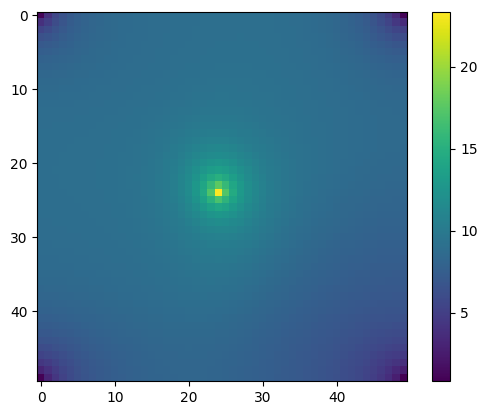

In [5]:
from matplotlib.colors import LogNorm

plt.imshow(p.reshape(50, 50))
plt.colorbar()

Perfect! the simulation is running, i'll do some adjustments so it works better.

But basically i just need the `simulationpar` instance as configured by Marcio, it will be the same in all the simulations, i can use partial function application to deal with it, and the Y field.

First, let's check the grid coordinates since it is also an important information. There is a function called 

In [40]:
nx, ny = inputpar.mesh[0], inputpar.mesh[1]
Lx, Ly = inputpar.Dom[0], inputpar.Dom[1]
dx, dy = Lx / nx, Ly / ny
idx, coord = coordinates(nx, ny, Lx, Ly)

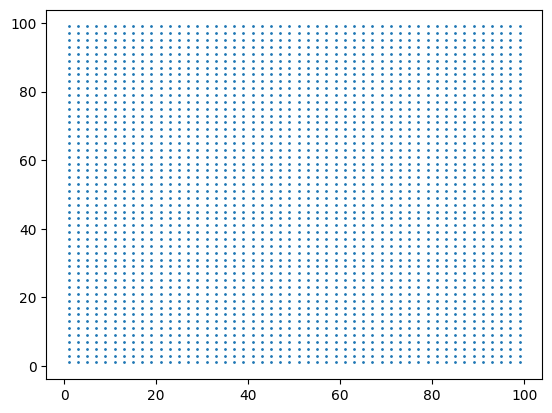

In [7]:
x, y = coord.T

plt.scatter(x, y, s=1)

In [8]:
pos

[255,
 755,
 1255,
 1755,
 2255,
 265,
 765,
 1265,
 1765,
 2265,
 275,
 775,
 1275,
 1775,
 2275,
 285,
 785,
 1285,
 1785,
 2285,
 295,
 795,
 1295,
 1795,
 2295]

I'll store this when i create the main dataset here.

# Testing field recreation from $\theta$ to $Y$

Let's check if i'm being able to recreate the fields using the KL transform coefficients.

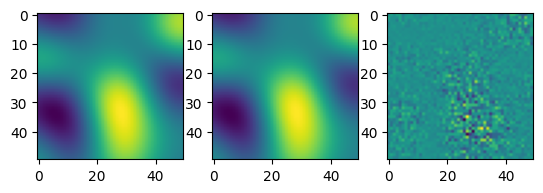

In [44]:
Y_reconstruct = (T["phi"]@theta_full["thetas"][100]).reshape(50, 50)

Y_original = Y_full["fields"][100].reshape(50, 50)

diff = Y_original - Y_reconstruct

fig, [ax1, ax2, ax3] = plt.subplots(ncols=3)

ax1.imshow(Y_original)
ax2.imshow(Y_reconstruct)
ax3.imshow(diff)

Looks just fine! Lets keep moving!

# Running simulations for all Y fields

In [46]:
from multiprocessing import Pool

parameters = [(inputpar, Y) for Y in Y_full["fields"]]

pool = Pool(processes=64)

presure_fields = pool.starmap(sim.five_spot_simulation, parameters)



In [47]:
presure_fields = np.array(presure_fields)

In [15]:
presure_fields.shape

(10000, 2500)

# Theta limits

One good information to have are the theta limits so i can use it to guide the training procedure.

In [23]:
theta_full["thetas"].max(axis=0), theta_full["thetas"].min(axis=0)

(array([3.955106 , 3.9596498, 3.6861117, 3.5106506, 3.7568548, 3.3217402,
        3.701209 , 3.5632763, 3.7083585, 3.6076496, 4.061559 , 3.8849044,
        4.0026183, 3.6254241, 3.6179702, 3.7063828, 3.4541414, 3.8129737,
        3.7949831, 3.415093 , 3.4778528, 4.0029054, 4.3342166, 3.9605212],
       dtype=float32),
 array([-4.133799 , -3.6841002, -3.4827223, -3.9614818, -3.813118 ,
        -4.0287733, -3.9729419, -3.6916056, -3.9193726, -3.4986956,
        -3.7481508, -3.4405072, -3.587718 , -3.9806464, -3.8761833,
        -4.124586 , -3.6848495, -3.70764  , -4.345283 , -3.6419463,
        -3.6588745, -4.201554 , -3.3788745, -4.3531203], dtype=float32))

# Saving data into HDF5

In [48]:
import h5py

from pathlib import Path

SAVE_HDF5 = True
OUTPUT_FILE = Path("../../outputs/poisson_pressure_simulations.h5")

if not OUTPUT_FILE.exists() and SAVE_HDF5:

    with h5py.File(OUTPUT_FILE, "w") as f:
    
        # Store shared time array (compressed)
        pos = f.create_dataset("positions", data=coord, compression="gzip")
        pos.attrs["description"] = "These are the positions (x,y) on which the fields were calculated."

        sim = f.create_dataset("Y_fields", data=Y_full["fields"], compression="gzip")
        sim.attrs["description"] = "Y fields on 2_500 positions."

        sim = f.create_dataset("pressure_fields", data=presure_fields, compression="gzip")
        sim.attrs["description"] = "fields calculated via the poisson problem in 2_500 positions."

        pars = f.create_dataset("kl_coefficients", data=theta_full["thetas"], compression="gzip")
        pars.attrs["description"] = "Matrice with the coefficients for reconstructing the Y field (to be used as training parameters)"

        pars = f.create_dataset("kl_transform_matrice", data=T["phi"], compression="gzip")
        pars.attrs["description"] = "Projection matrice to return field Y from a set of 24 kl coefficients (for checking the output of the network)"

        pars = f.create_dataset("sensor_position_indexes", data=np.array(pos), compression="gzip")
        pars.attrs["description"] = "Indexes of places on which sensors are placed, to be used for inversion problem."

        # Add global metadata
        f.attrs["author"] = "João Pedro Rocha (jpssrocha)"
        f.attrs["repo"] = "deeponet-jax-inversion"
        f.attrs["description"] = (
        """
        This dataset contains simulations for many pressure fields from the problem described at:

        > https://arxiv.org/pdf/2507.00020

        They were generated using files provided by the main author of the paper.

        Descriptions for each dataset are described on them. They're organized in a way to facilitate 
        training a DeepONet with it. This is the TRAINING SET.
        """)